## Classical Neural Network → Quantum Neural Network

In [1]:
%pip install pennylane pennylane-lightning torch scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


### Cell 1 — Imports & Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn

import pennylane as qml
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split


### Cell 2 — Dataset (Shared, Controlled)

We use a regression task, which makes loss curves meaningful.

In [3]:
X, y = make_regression(
    n_samples=400,
    n_features=4,
    noise=0.2,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


Torch conversion:

In [4]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)


### Cell 3 — Progress Axis (SVM-STYLE)

In [5]:
EPOCHS = 60

### Cell 4 — Metrics Template (IDENTICAL STRUCTURE)

In [6]:
metrics_classical = {
    "progress": [],
    "performance": []
}

metrics_quantum = {
    "progress": [],
    "performance": []
}


## Classical Neural Network

### Cell 5 — Classical Model Definition

In [7]:
class ClassicalNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()


### Cell 6 — Classical Training Loop (WITH METRICS)

In [8]:
model = ClassicalNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(EPOCHS):
    preds = model(X_train_t)
    loss = loss_fn(preds, y_train_t)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 🔴 METRIC COLLECTION (SVM-STYLE)
    metrics_classical["progress"].append(epoch)
    metrics_classical["performance"].append(loss.item())


##  Quantum Neural Network (QNN)


### Cell 7 — Quantum Circuit Definition

In [9]:
N_QUBITS = 4
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def qnn(x, weights):
    qml.AngleEmbedding(x, wires=range(N_QUBITS))
    qml.BasicEntanglerLayers(weights, wires=range(N_QUBITS))
    return qml.expval(qml.PauliZ(0))


### Cell 8 — Quantum Training Loop (WITH METRICS)

We train a variational quantum circuit as a function approximator.

In [10]:
weights = torch.nn.Parameter(torch.randn(2, N_QUBITS))
optimizer_q = torch.optim.Adam([weights], lr=0.1)

for epoch in range(EPOCHS):

    loss = 0
    for x, y in zip(X_train_t, y_train_t):
        loss += (qnn(x, weights) - y) ** 2

    optimizer_q.zero_grad()
    loss.backward()
    optimizer_q.step()

    # 🔴 METRIC COLLECTION (MATCHES CLASSICAL)
    metrics_quantum["progress"].append(epoch)
    metrics_quantum["performance"].append(loss.item() / len(X_train_t))


### Cell 9 — Performance Comparison Plot

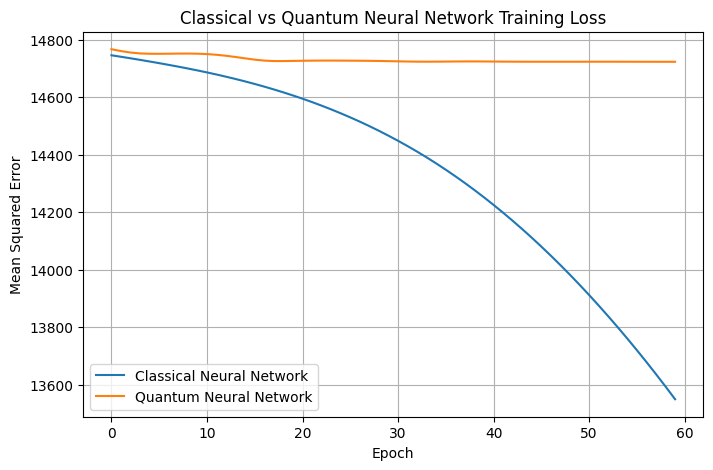

In [11]:
plt.figure(figsize=(8, 5))

plt.plot(
    metrics_classical["progress"],
    metrics_classical["performance"],
    label="Classical Neural Network"
)

plt.plot(
    metrics_quantum["progress"],
    metrics_quantum["performance"],
    label="Quantum Neural Network"
)

plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Classical vs Quantum Neural Network Training Loss")
plt.legend()
plt.grid(True)
plt.show()


### Cell 10 — Final Results Table

In [12]:
results = pd.DataFrame({
    "Model": ["Classical NN", "Quantum NN"],
    "Final Training Loss": [
        metrics_classical["performance"][-1],
        metrics_quantum["performance"][-1]
    ],
    "Average Training Loss": [
        np.mean(metrics_classical["performance"]),
        np.mean(metrics_quantum["performance"])
    ]
})

results


,Model,Final Training Loss,Average Training Loss
0,Classical NN,13548.867188,14347.874333
1,Quantum NN,14723.532175,14731.536151


**Paper framing:**
“Quantum neural networks replace hidden layers with parametrized quantum circuits.”